In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
from skimage.transform import resize
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.utils import Bunch

### Function to import the necessary datasets

In [ ]:
def create_dataset(path):
    directory = Path(path)
    characters_dir = [_ for _ in directory.iterdir()]
    characters_name = [_.name for _ in characters_dir]

    images = []
    classes = []
    for y, dire in enumerate(characters_dir):
        for img in dire.iterdir():
            
            img = np.array(Image.open(img))
            img_resized = resize(img, (64, 64), anti_aliasing=True)    # resizing the image in 64x64
            images.append(img_resized.flatten()) 
            classes.append(y)

    images = np.array(images)
    classes = np.array(classes)
    
    return Bunch(data = images, target = classes, target_names = characters_name)

In [ ]:
data = create_dataset('/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset')

In [ ]:
def pair_shuffle(list1, list2):
    l = list(zip(list1, list2))
    import random
    random.shuffle(l)
    return zip(*l)

In [ ]:
X, y = pair_shuffle(data.data, data.target)

### Function to plot the images with their labels from the dataset

In [ ]:
def plotting(n, m, data, labels, names):
    import matplotlib.pyplot as plt
    plt.figure(figsize = (10, 10))
    for _ in range(n):
        for __ in range(m):
            index = _*m + __
            plt.subplot(n, m, index + 1)
            plt.axis("off")
            plt.imshow(data[index].reshape((64, 64, 3)))
            plt.title(names[int(labels[index])], fontsize = 10)
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

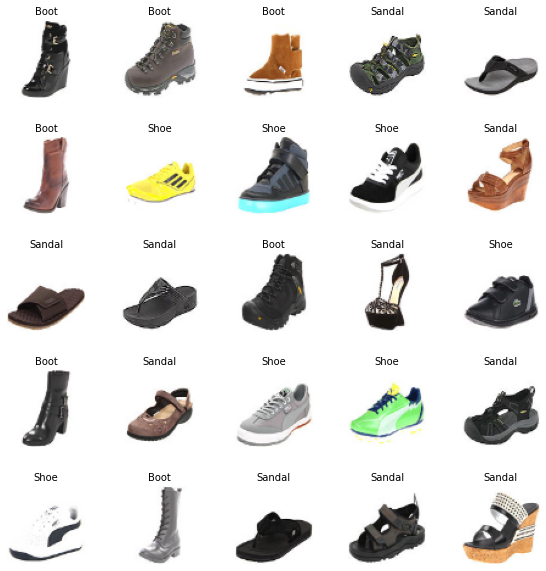

In [ ]:
plotting(5, 5, X, y, data.target_names)

In [ ]:
data.data.shape, len(data.target), len(data.target_names)

((15000, 12288), 15000, 3)

In [ ]:
X, y = np.array(X), np.array(y)

### Creating Training, Validation and Test Sets

In [ ]:
n = len(X)
train_X, val_X, test_X = X[:n*2//3], X[n*2//3:n*4//5], X[n*4//5:]
train_y, val_y, test_y = y[:n*2//3], y[n*2//3:n*4//5], y[n*4//5:]

### Creating a MLP model

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [12288]))
model.add(keras.layers.Dense(3000, 'relu'))
model.add(keras.layers.Dense(1000, 'relu'))
model.add(keras.layers.Dense(100, 'relu'))
model.add(keras.layers.Dense(3, 'softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 3000)              36867000  
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
dense_9 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 303       
Total params: 39,968,403
Trainable params: 39,968,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.01)

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [ ]:
model1 = model.fit(train_X, train_y, epochs = 40, validation_data = (val_X, val_y))

Epoch 1/40
313/313 [==============================] - 32s 101ms/step - loss: 0.7515 - accuracy: 0.6894 - val_loss: 0.5590 - val_accuracy: 0.7625
Epoch 2/40
313/313 [==============================] - 31s 100ms/step - loss: 0.4675 - accuracy: 0.8026 - val_loss: 0.6656 - val_accuracy: 0.6975
Epoch 3/40
313/313 [==============================] - 32s 101ms/step - loss: 0.3975 - accuracy: 0.8415 - val_loss: 0.3597 - val_accuracy: 0.8470
Epoch 4/40
313/313 [==============================] - 32s 101ms/step - loss: 0.3506 - accuracy: 0.8650 - val_loss: 0.2885 - val_accuracy: 0.8935
Epoch 5/40
313/313 [==============================] - 32s 101ms/step - loss: 0.3273 - accuracy: 0.8729 - val_loss: 0.3149 - val_accuracy: 0.8685
Epoch 6/40
313/313 [==============================] - 31s 100ms/step - loss: 0.2999 - accuracy: 0.8846 - val_loss: 0.2595 - val_accuracy: 0.8985
Epoch 7/40
313/313 [==============================] - 32s 101ms/step - loss: 0.2729 - accuracy: 0.8958 - val_loss: 0.3270 - val_ac

In [ ]:
model.evaluate(test_X, test_y)

94/94 [==============================] - 4s 40ms/step - loss: 0.1641 - accuracy: 0.9423


[0.1640760898590088, 0.9423333406448364]

### On the test set, we see an accuracy of over 94%

In [ ]:
model1.params

{'verbose': 1, 'epochs': 40, 'steps': 313}

<AxesSubplot:>

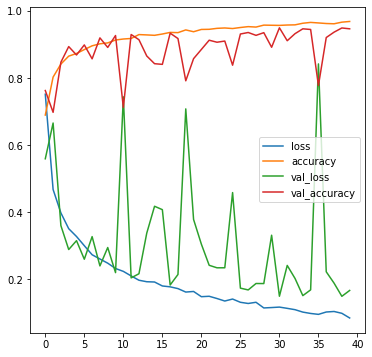

In [ ]:
pd.DataFrame(model1.history).plot(figsize=(6,6))

In [ ]:
def build_model(hidden_layers = 2, n_neurons = 1000, learning_rate = 0.01):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [12288]))
    for _ in range(hidden_layers):
        model.add(keras.layers.Dense(n_neurons, "relu"))
    model.add(keras.layers.Dense(3, "softmax"))
    opt = keras.optimizers.SGD(learning_rate= learning_rate)
    model.compile(opt, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    return model

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

### Fine tuning the hyperparameters of our model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param = {
    "hidden_layers": range(2,6),
    "n_neurons": np.arange(100, 3000),
    "learning_rate": [0.02, 0.01]
}
rnd = RandomizedSearchCV(keras_reg, param, n_iter= 8, cv = 3)
rnd.fit(train_X, train_y, epochs = 40, validation_data=(val_X, val_y), callbacks = [keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/40
209/209 [==============================] - 5s 24ms/step - loss: 0.8155 - accuracy: 0.6142 - val_loss: 0.8026 - val_accuracy: 0.6420
Epoch 2/40
209/209 [==============================] - 5s 26ms/step - loss: 0.5735 - accuracy: 0.7574 - val_loss: 0.4614 - val_accuracy: 0.8075
Epoch 3/40
209/209 [==============================] - 5s 23ms/step - loss: 0.5018 - accuracy: 0.7882 - val_loss: 0.6247 - val_accuracy: 0.7285
Epoch 4/40
209/209 [==============================] - 5s 22ms/step - loss: 0.4364 - accuracy: 0.8213 - val_loss: 0.4260 - val_accuracy: 0.8205
Epoch 5/40
209/209 [==============================] - 5s 23ms/step - loss: 0.3976 - accuracy: 0.8383 - val_loss: 0.4848 - val_accuracy: 0.7975
Epoch 6/40
209/209 [==============================] - 5s 22ms/step - loss: 0.3710 - accuracy: 0.8510 - val_loss: 0.4647 - val_accuracy: 0.8215
Epoch 7/40
209/209 [==============================] - 5s 22ms/step - loss: 0.3645 - accuracy: 0.8579 - val_loss: 0.3851 - val_accuracy: 0.8535

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fa000317dd0>,
                   n_iter=8,
                   param_distributions={'hidden_layers': range(2, 6),
                                        'learning_rate': [0.02, 0.01],
                                        'n_neurons': array([ 100,  101,  102, ..., 2997, 2998, 2999])})

In [ ]:
print(rnd.best_params_)
print(rnd.best_score_)

{'n_neurons': 2636, 'learning_rate': 0.02, 'hidden_layers': 4}
-0.20691344141960144


In [ ]:
final_model = rnd.best_estimator_.model

In [ ]:
f_m = final_model.fit(train_X, train_y, epochs = 40, validation_data = (val_X, val_y))

Epoch 1/40
313/313 [==============================] - 49s 156ms/step - loss: 0.1590 - accuracy: 0.9401 - val_loss: 0.1828 - val_accuracy: 0.9370
Epoch 2/40
313/313 [==============================] - 49s 157ms/step - loss: 0.1442 - accuracy: 0.9464 - val_loss: 0.2596 - val_accuracy: 0.9055
Epoch 3/40
313/313 [==============================] - 49s 156ms/step - loss: 0.1494 - accuracy: 0.9407 - val_loss: 0.1687 - val_accuracy: 0.9450
Epoch 4/40
313/313 [==============================] - 49s 157ms/step - loss: 0.1369 - accuracy: 0.9484 - val_loss: 0.1778 - val_accuracy: 0.9385
Epoch 5/40
313/313 [==============================] - 48s 154ms/step - loss: 0.1404 - accuracy: 0.9482 - val_loss: 0.2607 - val_accuracy: 0.9010
Epoch 6/40
313/313 [==============================] - 49s 157ms/step - loss: 0.1350 - accuracy: 0.9483 - val_loss: 0.1715 - val_accuracy: 0.9410
Epoch 7/40
313/313 [==============================] - 48s 155ms/step - loss: 0.1280 - accuracy: 0.9525 - val_loss: 0.2722 - val_ac

<AxesSubplot:>

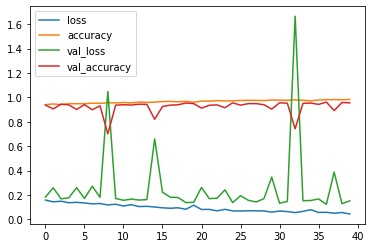

In [ ]:
import pandas as pd
pd.DataFrame(f_m.history).plot()

In [ ]:
final_model.evaluate(test_X, test_y)

94/94 [==============================] - 5s 53ms/step - loss: 0.1429 - accuracy: 0.9577


[0.1428855061531067, 0.9576666951179504]

### We get an accuracy of over 95% on the test set!

In [ ]:
pred_X = test_X[:6]
pred_y = final_model.predict(pred_X)
classes_y = np.argmax(pred_y, axis=1)

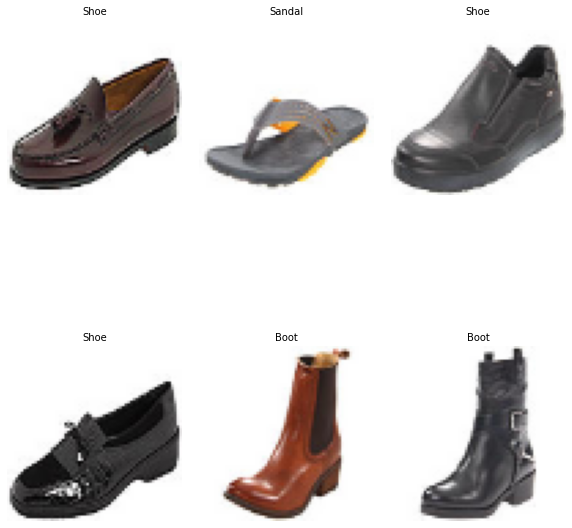

In [ ]:
plotting(2, 3, pred_X, classes_y, data.target_names)